## 0. Import and EDA

In [14]:
creds = ''

In [15]:
from pathlib import Path

cred_path = Path('kaggle.json')

In [16]:
path_data = Path('data')
path_comp = Path('us-patent-phrase-to-phrase-matching')
path = path_data / path_comp

In [17]:
if not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path_comp))
    zipfile.ZipFile(f"{path_comp}.zip").extractall(path)

In [18]:
%ls {path}

sample_submission.csv  test.csv  train.csv


In [19]:
import pandas as pd

In [20]:
df = pd.read_csv(path/'train.csv')

In [21]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [22]:
df.describe(include=object)

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,8d135da0b55b8c88,component composite coating,composition,H01
freq,1,152,24,2186


In [23]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

In [24]:
df.input.head()

,input
0,TEXT1: A47; TEXT2: abatement of pollution; ANC...
1,TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2,TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3,TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4,TEXT1: A47; TEXT2: forest region; ANC1: abatement


## 1. Tokenization

In [28]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)

In [29]:
model_nm = 'microsoft/deberta-v3-small'

In [30]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm, use_fast=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [31]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [32]:
def tok_func(x): return tokz(x["input"])

In [33]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [34]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [35]:
tokz.vocab['▁of']

265

In [36]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

## 2. Test and Validation Sets

In [37]:
eval_df = pd.read_csv(path/"test.csv")
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,hybrid bearing,inorganic photoconductor drum,G02
freq,1,2,1,3


In [38]:
def f(x): return -3*x**2 + 2*x + 20

In [39]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color="r"):
    x = np.linspace(min, max, 100)[:, None]
    plt.plot(x, f(x), color)

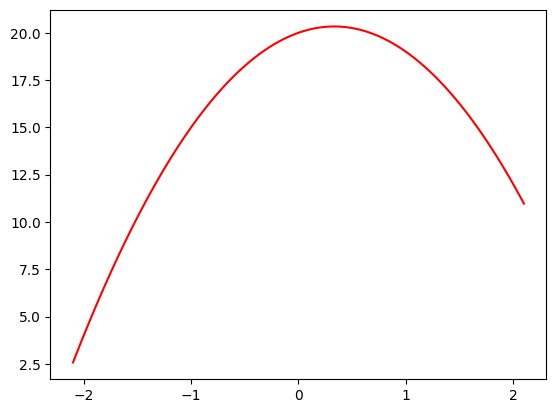

In [40]:
plot_function(f)

In [41]:
from numpy.random import normal, uniform

In [42]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x, mult)) + noise(x, add)

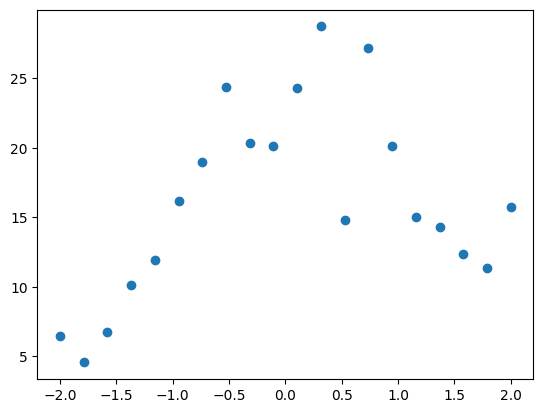

In [43]:
x = np.linspace(-2, 2, num=20)[:, None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x, y)

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x, y)
    plot_function(model.predict)

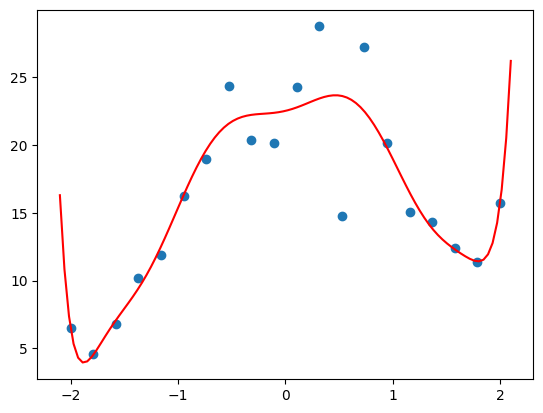

In [45]:
# Overfit model
plot_poly(10)

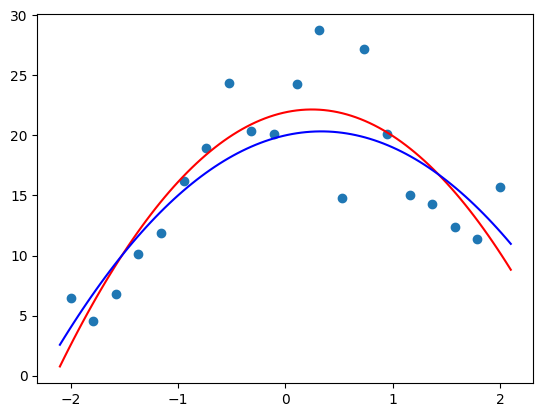

In [46]:
# Let's try instead a degree 2 polynomial
# The blue line is our "true" function
plot_poly(2)
plot_function(f, color="b")

In [47]:
dds = tok_ds.train_test_split(0.25)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [48]:
eval_df['input'] = 'Text1: ' + eval_df.context + '; Text2: ' + eval_df.target + '; Anc1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

## 3. Metrics and Correlation

In [73]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20046,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,0.47700
3024,2.5313,30.0,5.039384,1.193493,1565.0,2.679795,35.14,-119.46,0.45800
15663,3.4801,52.0,3.977155,1.185877,1310.0,1.360332,37.80,-122.44,5.00001
20484,5.7376,17.0,6.163636,1.020202,1705.0,3.444444,34.28,-118.72,2.18600
9814,3.7250,34.0,5.492991,1.028037,1063.0,2.483645,36.62,-121.93,2.78000


In [50]:
np.set_printoptions(precision=2, suppress=True)
np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.09,  0.4 , -0.08, -0.01, -0.04, -0.03, -0.03,  0.64],
       [-0.09,  1.  , -0.18, -0.09, -0.33,  0.  , -0.  , -0.11,  0.09],
       [ 0.4 , -0.18,  1.  ,  0.73, -0.09, -0.05,  0.14, -0.03,  0.15],
       [-0.08, -0.09,  0.73,  1.  , -0.09, -0.09,  0.07,  0.04, -0.07],
       [-0.01, -0.33, -0.09, -0.09,  1.  ,  0.22, -0.11,  0.11, -0.04],
       [-0.04,  0.  , -0.05, -0.09,  0.22,  1.  , -0.12,  0.13, -0.23],
       [-0.03, -0.  ,  0.14,  0.07, -0.11, -0.12,  1.  , -0.93, -0.14],
       [-0.03, -0.11, -0.03,  0.04,  0.11,  0.13, -0.93,  1.  , -0.03],
       [ 0.64,  0.09,  0.15, -0.07, -0.04, -0.23, -0.14, -0.03,  1.  ]])

In [51]:
# This works well when we're getting a bunch of numbers at once, but it's overkill when we want a single coefficient
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.64],
       [0.64, 1.  ]])

In [52]:
def corr(x, y): return np.corrcoef(x, y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

np.float64(0.6376281824897945)

In [53]:
def show_corr(df, a, b):
    x, y = df[a], df[b]
    plt.scatter(x, y, alpha=0.5, s=4)
    plt.title(f"{a} vs {b}; r: {corr(x, y):.2f}")

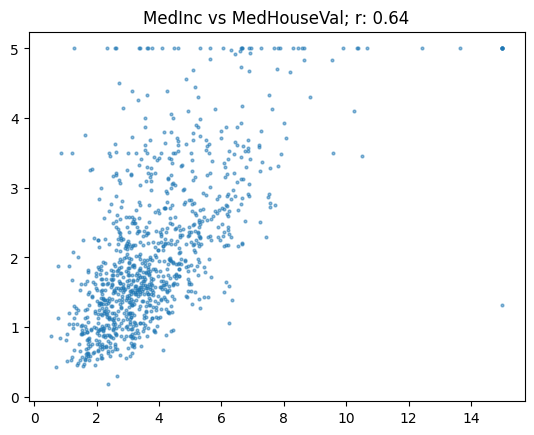

In [54]:
show_corr(housing, 'MedInc', 'MedHouseVal')

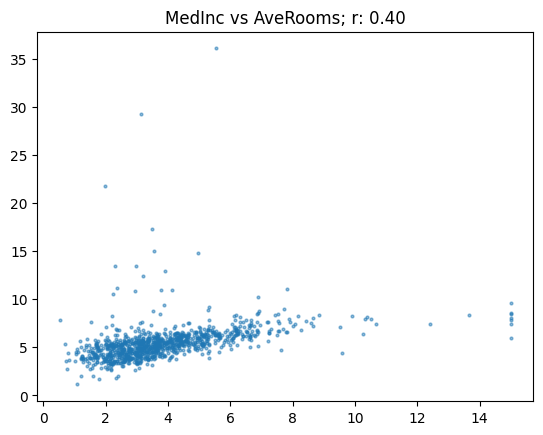

In [55]:
show_corr(housing, 'MedInc', 'AveRooms')

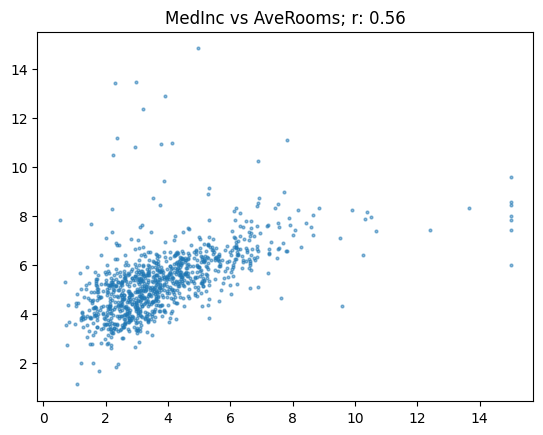

In [56]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

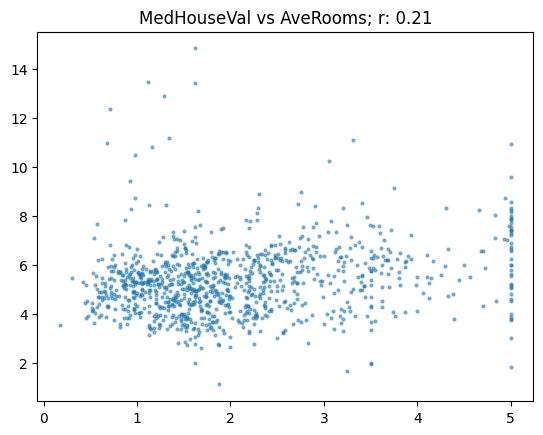

In [57]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

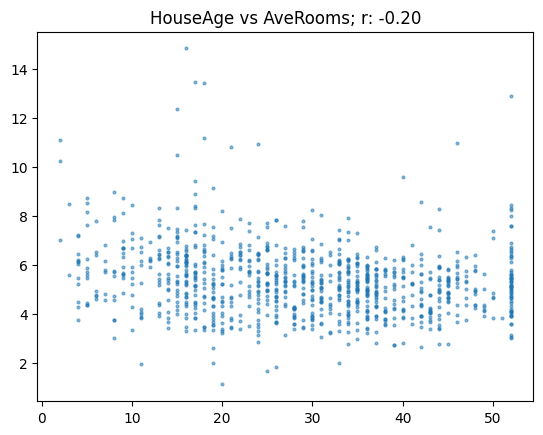

In [58]:
show_corr(subset, 'HouseAge', 'AveRooms')

In [59]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

## Training

In [60]:
from transformers import TrainingArguments, Trainer

We pick a batch size that fits our GPU, and small number of epochs so we can run experiments quickly:

In [61]:
bs = 128
epochs = 4

In [62]:
lr = 8e-5

Transformers uses the TrainingArguments class to set up arguments. Don't worry too much about the values we're using here -- they should generally work fine in most cases. It's just the 3 parameters above that you may need to change for different models.

In [68]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
                         eval_strategy='epoch', per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
                         num_train_epochs=epochs, weight_decay=0.01, report_to=[])

In [69]:
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [70]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], processing_class=tokz, compute_metrics=corr_d)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025652,0.802863
2,No log,0.023744,0.830158
3,0.030300,0.021798,0.837649
4,0.030300,0.022059,0.838496


TrainOutput(global_step=856, training_loss=0.02335566616503992, metrics={'train_runtime': 216.5993, 'train_samples_per_second': 505.154, 'train_steps_per_second': 3.952, 'total_flos': 726755465730660.0, 'train_loss': 0.02335566616503992, 'epoch': 4.0})

In [72]:
preds = trainer.predict(eval_ds).predictions.astype('float')
preds

array([[ 0.58],
       [ 0.66],
       [ 0.5 ],
       [ 0.36],
       [-0.03],
       [ 0.58],
       [ 0.47],
       [-0.01],
       [ 0.38],
       [ 1.06],
       [ 0.25],
       [ 0.25],
       [ 0.72],
       [ 0.85],
       [ 0.76],
       [ 0.35],
       [ 0.3 ],
       [-0.01],
       [ 0.63],
       [ 0.37],
       [ 0.43],
       [ 0.22],
       [ 0.09],
       [ 0.22],
       [ 0.57],
       [-0.02],
       [-0.03],
       [-0.02],
       [-0.03],
       [ 0.68],
       [ 0.27],
       [-0.03],
       [ 0.67],
       [ 0.52],
       [ 0.49],
       [ 0.15]])

In [74]:
preds = np.clip(preds, 0, 1)

In [75]:
preds

array([[0.58],
       [0.66],
       [0.5 ],
       [0.36],
       [0.  ],
       [0.58],
       [0.47],
       [0.  ],
       [0.38],
       [1.  ],
       [0.25],
       [0.25],
       [0.72],
       [0.85],
       [0.76],
       [0.35],
       [0.3 ],
       [0.  ],
       [0.63],
       [0.37],
       [0.43],
       [0.22],
       [0.09],
       [0.22],
       [0.57],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.68],
       [0.27],
       [0.  ],
       [0.67],
       [0.52],
       [0.49],
       [0.15]])

In [77]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

853